## 01. PyTorch Workflow

**An example PyTorch end-to-end workflow.**
1. get data (prepare and load) (turn into tensors)
2. build or pick a pretrained model
3. fit the model to data (training)
4. make predictions and evaluate the model (inference)
5. saving and loading a model
6. put all together

In [1]:
import torch
# nn -> contains all of pytorch's building blocks for neural networks
# https://pytorch.org/docs/stable/nn.html
from torch import nn
import matplotlib.pyplot as plt

### 1. Data Preparation

excel speadsheet / images / videos / audio / text ...

-> get data into a numberical representation.

-> build a model to learn patterns in that numberical representation.

Use a linear regression formula to make a straight line with known *parameters*.

In [2]:
# parameters
weight = 0.7
bias = 0.3

start = 0
end = 1
step = 0.02
X = torch.arange(start, end, step).unsqueeze(dim=1)
y = weight * X + bias

print(X[:10])
print(y[:10])
print(len(X), len(y))

tensor([[0.0000],
        [0.0200],
        [0.0400],
        [0.0600],
        [0.0800],
        [0.1000],
        [0.1200],
        [0.1400],
        [0.1600],
        [0.1800]])
tensor([[0.3000],
        [0.3140],
        [0.3280],
        [0.3420],
        [0.3560],
        [0.3700],
        [0.3840],
        [0.3980],
        [0.4120],
        [0.4260]])
50 50


**Splitting data into training and testng sets**

In [3]:
train_split = int(0.8 * len(X))
X_train, y_train = X[:train_split], y[:train_split]
X_test, y_test = X[train_split:], y[train_split:]

In [4]:
# visualize
def plot_predictions(train_data=X_train, 
                     train_labels=y_train, 
                     test_data=X_test, 
                     test_labels=y_test, 
                     predictions=None):
    """
    Plots training data, test data and compares predictions
    """
    plt.figure(figsize=(8, 6))

    plt.scatter(train_data, train_labels, c="b", s=4, label="Training data")

    plt.scatter(test_data, test_labels, c="g", s=4, label="Testing data")

    if predictions is not None:
        plt.scatter(test_data, predictions, c="r", s=4, label="Predictions")

    # Show the legend
    plt.legend(prop={"size": 14})
    plt.grid()

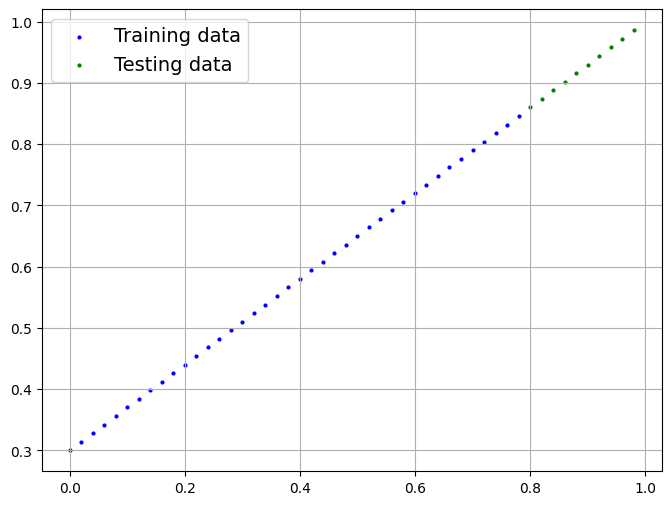

In [5]:
plot_predictions()

### 2. Build PyTorch model

**2 main algorithms:**
- Gradient descent
- backpropagation

In [6]:
# create a linear regression model class
class LinearRegressionModel(nn.Module):
    # almost everything in PyTorch inherits from nn.Module
    def __init__(self):
        super().__init__()
        # a kind of Tensor that is to be considered a module parameter
        self.weights = nn.Parameter(torch.rand(1,
                                               requires_grad=True,  # gd -> True
                                               dtype=torch.float))
        self.bias = nn.Parameter(torch.rand(1,
                                            requires_grad=True,
                                            dtype=torch.float))

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """ to define the computation in the model """
        # x: input data
        return self.weights * x + self.bias
